Dataset : https://drive.google.com/drive/folders/1P4XPsBgkIYHaq2qaQjr1PysnOjydRsRw?usp=drive_link 

In [ ]:
# Import pustaka penting
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = '/content/drive/MyDrive/comvis/dataset/'
MODEL_PATH = '/content/drive/MyDrive/comvis/efficientnet_b2_anti_overfit.keras'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR + 'train',
    image_size=(260, 260),
    label_mode='binary',
    color_mode='rgb',
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR + 'val',
    image_size=(260, 260),
    label_mode='binary',
    color_mode='rgb',
    batch_size=32
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 8863 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
], name="data_augmentation")


In [ ]:
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))
base_model.trainable = False

inputs = Input(shape=(260, 260, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)  # lebih kecil dari 128
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(MODEL_PATH,monitor='val_accuracy',save_best_only=True,mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

callbacks = [early_stop, checkpoint, reduce_lr]

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=callbacks)


Epoch 1/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5465 - loss: 0.7063
Epoch 1: val_accuracy improved from -inf to 0.62667, saving model to /content/drive/MyDrive/comvis/efficientnet_b2_anti_overfit.keras
277/277 ━━━━━━━━━━━━━━━━━━━━ 97s 291ms/step - accuracy: 0.5466 - loss: 0.7062 - val_accuracy: 0.6267 - val_loss: 0.6138 - learning_rate: 1.0000e-04
Epoch 2/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.6158 - loss: 0.6493
Epoch 2: val_accuracy improved from 0.62667 to 0.73000, saving model to /content/drive/MyDrive/comvis/efficientnet_b2_anti_overfit.keras
277/277 ━━━━━━━━━━━━━━━━━━━━ 48s 172ms/step - accuracy: 0.6159 - loss: 0.6492 - val_accuracy: 0.7300 - val_loss: 0.5579 - learning_rate: 1.0000e-04
Epoch 3/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6659 - loss: 0.6041
Epoch 3: val_accuracy did not improve from 0.73000
277/277 ━━━━━━━━━━━━━━━━━━━━ 80s 164ms/step - accuracy: 0.6659 - loss: 0.6041 - val_accuracy: 0.7250 - val_loss: 0.538

In [ ]:
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=callbacks)


Epoch 1/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.6271 - loss: 0.6586
Epoch 1: val_accuracy did not improve from 0.75167
277/277 ━━━━━━━━━━━━━━━━━━━━ 265s 730ms/step - accuracy: 0.6272 - loss: 0.6584 - val_accuracy: 0.7000 - val_loss: 0.5640 - learning_rate: 1.0000e-05
Epoch 2/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.7376 - loss: 0.5213
Epoch 2: val_accuracy did not improve from 0.75167
277/277 ━━━━━━━━━━━━━━━━━━━━ 254s 702ms/step - accuracy: 0.7377 - loss: 0.5212 - val_accuracy: 0.7033 - val_loss: 0.5329 - learning_rate: 1.0000e-05
Epoch 3/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.8139 - loss: 0.4163
Epoch 3: val_accuracy did not improve from 0.75167
277/277 ━━━━━━━━━━━━━━━━━━━━ 202s 704ms/step - accuracy: 0.8140 - loss: 0.4162 - val_accuracy: 0.6717 - val_loss: 0.5750 - learning_rate: 1.0000e-05
Epoch 4/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.8725 - loss: 0.3098
Epoch 4: val_accuracy did not improve from 0.751

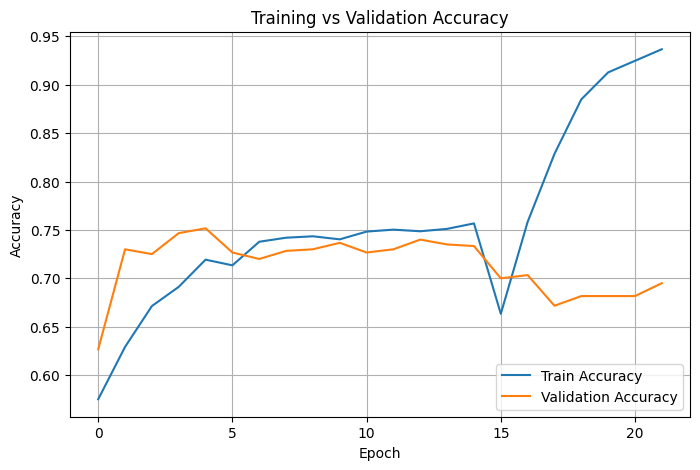

In [ ]:
acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/comvis/acc_anti_overfit.png')
plt.show()



In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"\n✅ Final Validation Accuracy: {acc * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.7023 - loss: 0.5410

✅ Final Validation Accuracy: 70.33%
